A standalone notebook to 
1. Generate synthetic training data with Govindjee
2. Train Govindjee VMM with this synthetic data by starting from random parameters
3. Pretrain $\Psi_{EQ}$ and $\Psi_{NEQ}$
4. Pretrain $\Phi$ with the $\Phi$ from Govindjee 
5. Retrain the whole model with P01 stress-stretch data

all in a single notebook. It needs NODE_fns.py to function. This notebook and 
nvisco_synthetic.py contain essentially the same stuff, except for figures. 
nvisco_synthetic.py was made to run this notebook on the cluster and instead 
of showing the figures it just saves them.

In [1]:
# Import and initialize
from jax.config import config
config.update('jax_platform_name', 'cpu') #Otherwise jax displays an annoying warning every time
config.update('jax_disable_jit', False)
config.update('jax_enable_x64', True)

import jax.numpy as np
import numpy as onp
import matplotlib.pyplot as plt
import matplotlib
font = {'size'   : 14}
matplotlib.rc('font', **font)
from NODE_fns import NODE_old as NODE, NODE_nobias, sigma_split as sigma_NODE, sigma_split_vmap
from jax import grad, random, jit, vmap
from functools import partial
import jax.example_libraries.optimizers as optimizers
from jax.lax import cond
from jax.experimental.ode import odeint
from diffrax import diffeqsolve, ODETerm, SaveAt, Heun as mysolver
import pickle
key = random.PRNGKey(0)

from scipy.integrate import odeint

In [2]:
# Various useful functions
# 2 different functions to initialize 2 different NN architectures
def init_params_positivebias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    b = np.zeros(layers[i + 1])
    return Ws, b
def init_params_nobias(layers, key):
    Ws = []
    for i in range(len(layers) - 1):
        std_glorot = np.sqrt(2/(layers[i] + layers[i + 1]))
        key, subkey = random.split(key)
        Ws.append(random.normal(subkey, (layers[i], layers[i + 1]))*std_glorot)
    return Ws

def dPhi_gov(tau_i, etad = 1360, etav = 175000): 
    tau1, tau2, tau3 = tau_i
    trtau = tau1 + tau2 + tau3
    dphidtau1 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau2+tau3)
    dphidtau2 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau3)
    dphidtau3 = 2*(1/3/etad + 1/9/etav)*trtau - 1/etad*(tau1+tau2)
    return [dphidtau1, dphidtau2, dphidtau3]
dPhi_gov_vmap = vmap(dPhi_gov, in_axes=(0, None, None), out_axes=(0))

# Neural ODE based dPhi/dtaui
def dPhi_NODE(taui, Phi_params):
    # NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params = Phi_params
    NODE3_params, NODE4_params, NODE5_params = Phi_params
    tau1 = taui[0]
    tau2 = taui[1]
    tau3 = taui[2]

    I3 = tau1 + tau2 + tau3
    I4 = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
    I5 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

    I3 = I3/inp_std3
    I4 = I4/inp_std4
    I5 = I5/inp_std5

    N3 = NODE(I3, NODE3_params)
    N4 = NODE(I4, NODE4_params) #I1^2
    N5 = NODE(I5, NODE5_params) #I1^2 - 3I2

    N1 = N2 = 0
    N3 = N3*out_std3
    N4 = N4*out_std4
    N5 = N5*out_std5

    Phi1 = N1 + N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau1 - tau2 - tau3) #dphi/dtau1
    Phi2 =      N2 + N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau2 - tau1 - tau3)
    Phi3 =           N3 + 2*N4*(tau1 + tau2 + tau3) + N5*(2*tau3 - tau1 - tau2)

    return [Phi1, Phi2, Phi3]
dPhi_vmap = vmap(dPhi_NODE, in_axes=(0, None), out_axes = (0))

def tau_Ogden(lm1e, lm2e, lm3e, Psi_neq_params):
    alpha_m, mu_m, K_m = Psi_neq_params
    Je = lm1e*lm2e*lm3e
    
    b1 = Je**(-2/3)*lm1e**2
    b2 = Je**(-2/3)*lm2e**2
    b3 = Je**(-2/3)*lm3e**2

    devtau1 = 0
    devtau2 = 0
    devtau3 = 0
    for r in range(3):
        e = alpha_m[r]/2
        devtau1 = devtau1 + mu_m[r]*(2/3*b1**e - 1/3*(b2**e + b3**e)) #(B8)
        devtau2 = devtau2 + mu_m[r]*(2/3*b2**e - 1/3*(b1**e + b3**e))
        devtau3 = devtau3 + mu_m[r]*(2/3*b3**e - 1/3*(b1**e + b2**e))
    devtau = np.array([devtau1, devtau2, devtau3])

    tau_NEQI = 3*(K_m*10000)/2*(Je**2-1) #(B8)
    tau_A = devtau + 1/3*tau_NEQI #(B8)
    return tau_A

def tau_NEQ_NODE(lm1, lm2, lm3, Psi_neq_params):
    J = lm1*lm2*lm3
    sigma_NEQ = sigma_NODE(lm1, lm2, lm3, Psi_neq_params)
    tau_NEQ = J*sigma_NEQ
    return tau_NEQ

def sigma_Ogden(lm1e, lm2e, lm3e, Psi_neq_params):
    tau_A = tau_Ogden(lm1e, lm2e, lm3e, Psi_neq_params)
    Je = lm1e*lm2e*lm3e
    tau_NEQ = np.array([[tau_A[0], 0, 0],
                        [0, tau_A[1], 0],
                        [0, 0, tau_A[2]]]) #Since stress and strain are coaxial in the isotropic case

    sigma_NEQ = 1/Je*tau_NEQ
    return sigma_NEQ
sigma_Ogden_vmap = vmap(sigma_Ogden, in_axes=(0,0,0,None), out_axes=0)

def sigma_neoHook(lm1, lm2, lm3, Psi_eq_params): #Neo hookean
    K, mu = Psi_eq_params
    J = lm1*lm2*lm3
    b = np.array([[lm1**2, 0, 0],
                [0, lm2**2, 0],
                [0, 0, lm3**2]])
    sigma_EQ = mu/J*(b-np.eye(3)) + (K*10000)*(J**2-1)/2/J*np.eye(3)
    return sigma_EQ
sigma_neoHook_vmap = vmap(sigma_neoHook, in_axes=(0,0,0,None), out_axes=0)

def sigma(inputs, params, useNODE):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = inputs
    if useNODE: # use NODE
        Psi_eq_params, Psi_neq_params, Phi_params = params
        sigma_EQ  = sigma_NODE(lm1, lm2, lm3, Psi_eq_params)
        sigma_NEQ = sigma_NODE(lm1e, lm2e, lm3e, Psi_neq_params)
    else: # use Govindjee
        gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = params
        sigma_NEQ = sigma_Ogden(lm1e, lm2e, lm3e, gov_Psi_neq_params)
        sigma_EQ = sigma_neoHook(lm1, lm2, lm3, gov_Psi_eq_params)
        # sigma_EQ = sigma_Ogden(lm1, lm2, lm3, gov_Psi_eq_params)
        
    sigma = sigma_NEQ + sigma_EQ
    return sigma
getsigma = vmap(sigma, in_axes=(0, None, None), out_axes=0)
dsigma33 = grad(lambda inputs, params, useNODE: sigma(inputs,params,useNODE)[2,2])


def yprime_biaxial(y, t, lm1dot, lm2dot, tpeak, params, useNODE):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y

    true_fun  = lambda t: np.array([lm1dot, lm2dot])
    false_fun = lambda t: np.array([   0.0,    0.0], dtype='float64')
    lm1dot, lm2dot = cond(t<tpeak, true_fun, false_fun, t)

    if useNODE: # use NODE 
        Psi_eq_params, Psi_neq_params, Phi_params = params
        tau_A = tau_NEQ_NODE(lm1e, lm2e, lm3e, Psi_neq_params) 
        tau_A = np.array([tau_A[0,0], tau_A[1,1], tau_A[2,2]])
        dphidtaui = dPhi_NODE(tau_A, Phi_params)
    else: # use Govindjee
        gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = params
        eta_D, eta_V = gov_Phi_params
        tau_A = tau_Ogden(lm1e, lm2e, lm3e, gov_Psi_neq_params) 
        dphidtaui = dPhi_gov(tau_A, eta_D, eta_V)

    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = (lm2dot/lm2 - 0.5*dphidtaui[1])*lm2e

    d = dsigma33([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    A = -(d[0]*lm1dot + d[1]*lm2dot + d[3]*lm1edot + d[4]*lm2edot)/d[2]
    B = -d[5]/d[2]

    Apr = A/lm3
    Bpr = B/lm3

    lm3edot = (Apr - 0.5*dphidtaui[2])/(1-Bpr*lm3e)*lm3e
    lm3dot = A + B*lm3edot
    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

def yprime_triaxial(y, t, lm1dot, tpeak, params, useNODE):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y

    true_fun  = lambda t: np.array(lm1dot)
    false_fun = lambda t: np.array(   0.0)
    lm1dot = cond(t<tpeak, true_fun, false_fun, t)

    if useNODE: # use NODE 
        Psi_eq_params, Psi_neq_params, Phi_params = params
        tau_A = tau_NEQ_NODE(lm1e, lm2e, lm3e, Psi_neq_params) 
        tau_A = np.array([tau_A[0,0], tau_A[1,1], tau_A[2,2]])
        dphidtaui = dPhi_NODE(tau_A, Phi_params)
    else: # use Govindjee
        gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = params
        eta_D, eta_V = gov_Phi_params
        tau_A = tau_Ogden(lm1e, lm2e, lm3e, gov_Psi_neq_params) 
        dphidtaui = dPhi_gov(tau_A, eta_D, eta_V)

    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = np.array(-0.5*dphidtaui[1]*lm2e)
    lm3edot = np.array(-0.5*dphidtaui[2]*lm3e)

    lm2dot = lm3dot = np.array(0)

    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

@partial(jit, static_argnums=(1,))
def biaxial_visco(params, useNODE, time, lm1, lm2):
    ipeak1 = np.argmax(np.abs(np.around(lm1, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    ipeak2 = np.argmax(np.abs(np.around(lm2, 3)-1.0))
    ipeak = np.max(np.array([ipeak1,ipeak2]))
    tpeak = time[ipeak]
    lm1peak = lm1[ipeak]
    lm2peak = lm2[ipeak]

    lm1dot = (lm1peak-1.0)/tpeak
    lm2dot = (lm2peak-1.0)/tpeak
    
    yprime = lambda t, y, args: np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE))
    term = ODETerm(yprime)
    solver = mysolver()
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=1.0, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()

    # yprime = lambda y, t: yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE)
    # y0 = [1.0,1.0,1.0,1.0,1.0,1.0]
    # lm1, lm2, lm3, lm1e, lm2e, lm3e = odeint(yprime, y0, time).transpose()

    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    return sig, lm1, lm2, lm3, lm1e, lm2e, lm3e

@partial(jit, static_argnums=(1,))
def triaxial_visco(params, useNODE, time, lamb):
    ipeak = np.argmax(np.abs(np.around(lamb, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    tpeak = time[ipeak]
    lambpeak = lamb[ipeak]

    lambdot = (lambpeak-1.0)/tpeak

    yprime = lambda t, y, args: np.array(yprime_triaxial(y,t,lambdot,tpeak,params,useNODE))
    term = ODETerm(yprime)
    solver = mysolver()
    y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    saveat = SaveAt(ts=time)
    solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=1.0, y0=y0, saveat=saveat)
    lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()

    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    return sig, lm1, lm2, lm3, lm1e, lm2e, lm3e

def moving_average(a, n=10):
    ret = onp.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    return ret[n - 1:] / n

def plot45(gts, prs, labels, title, constrained=True):
    nplots = len(gts)
    fig, ax = plt.subplots(1,nplots, figsize=(nplots*5,4))

    for i in range(nplots):
        xmin,xmax = np.min(gts[i]), np.max(gts[i])
        ax[i].plot([xmin,xmax], [xmin, xmax], 'r-')
        ax[i].plot(gts[i],prs[i], '.')
        ax[i].set(xlabel='Ground truth ' + labels[i],
                  ylabel='Predicted ' + labels[i])
        if constrained:
            ax[i].set(xlim = [xmin, xmax], ylim = [xmin, xmax])
    fig.suptitle(title)
    fig.subplots_adjust(wspace=0.4)

# 1. Generate synthetic training data

In [3]:
# material parameters
#Ogden:
alpha_m = np.array([1.8, -2, 7])
mu_m = np.array([51.4, -18, 3.86])
K_m = 1.0
gov_Psi_eq_params = [alpha_m, mu_m, K_m]

# Neo Hookean:
mu = 77.77
K = 1.0
gov_Psi_eq_params = [K, mu]

mu_m2 = np.array([51.4, -18, 3.86])
alpha_m2 = np.array([1.8, -2, 7])
K_m2 = 1.0
gov_Psi_neq_params = [alpha_m2, mu_m2, K_m2]

tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*(K_m*10000)
gov_Phi_params = [eta_D, eta_V]

gov_params = [gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params]

In [ ]:
lmb_x = []
lmb_y = []
sgm_x = []
sgm_y = []
time  = []
for eps_x_peak in np.linspace(-0.3,0.3,5):
    for eps_y_peak in np.linspace(-0.3,0.3,5):
        if eps_x_peak == 0 and eps_y_peak == 0:
            continue
        for t_peak in [10,20,30]:
            t_max = 100
            t = np.linspace(0,99,100)
            lm1 = np.hstack([np.linspace(1,1+eps_x_peak,t_peak), np.ones(t_max-t_peak)*(1+eps_x_peak)])
            lm2 = np.hstack([np.linspace(1,1+eps_y_peak,t_peak), np.ones(t_max-t_peak)*(1+eps_y_peak)])
            lm3 = 1/(lm1*lm2)

            sgm, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_visco(gov_params, False, t, lm1, lm2)
            lmb_x.append(lm1)
            lmb_y.append(lm2)
            sgm_x.append(sgm[:,0,0])
            sgm_y.append(sgm[:,1,1])
            time.append(t)
lmb_x = np.stack(lmb_x)
lmb_y = np.stack(lmb_y)
sgm_x = np.stack(sgm_x)
sgm_y = np.stack(sgm_y)
time = np.stack(time)

with open('training_data/gov_data.npy','wb') as f:
    np.save(f, [time, lmb_x, lmb_y, sgm_x, sgm_y])

# 2. Train Govindjee's model

In [5]:
with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = np.load(f)

In [6]:
def loss(params, useNODE, time, lm1, lm2, sigma1, sigma2):
    sigma_pr,_,_,_,_,_,_ = biaxial_visco(params, useNODE, time, lm1, lm2)
    loss = np.mean((sigma_pr[:,0,0]-sigma1)**2 + (sigma_pr[:,1,1]-sigma2)**2)
    return loss
loss_vmap = vmap(loss, in_axes=(None, None, 0, 0, 0, 0, 0), out_axes=0)
batch_loss = lambda params, useNODE, time, lm1, lm2, sigma1, sigma2: np.mean(loss_vmap(params, useNODE, time, lm1, lm2, sigma1, sigma2))

@partial(jit, static_argnums=(0,1,))
def step(loss_fn, useNODE, i, opt_state, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, useNODE, X1_batch, X2_batch, X3_batch, Y1_batch, Y2_batch)
    return opt_update(i, g, opt_state)

def train(X1, X2, X3, Y1, Y2, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(batch_loss, False, it, opt_state, X1[i], X2[i], X3[i], Y1[i], Y2[i])
        if it % 10 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, False, X1[i], X2[i], X3[i], Y1[i], Y2[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

In [7]:
# Initial guesses for material parameters
alpha_m = np.array([1.8, -2, 7])
mu_m = np.array([51.4, -18, 3.86])
K_m = 1.0

alpha_m = alpha_m + onp.random.normal(0,np.mean(alpha_m)/10, size=alpha_m.shape[0])
mu_m    = mu_m    + onp.random.normal(0,np.mean(mu_m)/10,    size=mu_m.shape[0])
K_m    = K_m    + onp.random.normal(0,K_m/10)
gov_Psi_eq_params = [alpha_m, mu_m, K_m]

mu_m2 = np.array([51.4, -18, 3.86])
alpha_m2 = np.array([1.8, -2, 7])
K_m2 = 1.0
alpha_m2 = alpha_m2 + onp.random.normal(0,np.mean(alpha_m2/10), size=alpha_m2.shape[0])
mu_m2    = mu_m2    + onp.random.normal(0,np.mean(mu_m2/10),    size=mu_m2.shape[0])
K_m2    = K_m2   + onp.random.normal(0,K_m2/10)
gov_Psi_neq_params = [alpha_m2, mu_m2, K_m2]

tau = 17.5
shear_mod = 1/2*(mu_m[0]*alpha_m[0] + mu_m[1]*alpha_m[1] + mu_m[2]*alpha_m[2])
eta_D = tau*shear_mod
eta_V = tau*(K_m*10000)

eta_D = eta_D + onp.random.normal(0,np.abs(eta_D)/10)
eta_V = eta_V + onp.random.normal(0,np.abs(eta_V)/10)
gov_Phi_params = [eta_D, eta_V]

gov_params = [gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params]

In [8]:
# I know this is a dumb way of doing it. please don't judge me.
# for lr in [1.0e-2, 1.0e-3, 1.0e-4, 1.0e-5]:
lr = 5.0e-5
opt_init, opt_update, get_params = optimizers.adam(lr)
opt_state = opt_init(gov_params)
gov_params, train_loss, val_loss = train(time, lmb_x, lmb_y, sgm_x, sgm_y, opt_state, key, nIter = 1000, batch_size=4)
    
with open('saved/gov_params.npy', 'wb') as f:
    pickle.dump(gov_params, f)

it 0, train loss = 5.433197e+01
it 10, train loss = 5.808201e+00
it 20, train loss = 5.342777e+01
it 30, train loss = 3.621701e+01
it 40, train loss = 5.906035e+00
it 50, train loss = 3.888734e+00
it 60, train loss = 2.737134e+01
it 70, train loss = 1.963045e+01
it 80, train loss = 9.921559e+00
it 90, train loss = 2.824565e+02
it 100, train loss = 4.766735e+01
it 110, train loss = 1.374564e+01
it 120, train loss = 2.834330e+01
it 130, train loss = 6.248529e+00
it 140, train loss = 1.279529e+01
it 150, train loss = 2.850641e+01
it 160, train loss = 6.507894e+00
it 170, train loss = 1.181448e+01
it 180, train loss = 4.828495e+00
it 190, train loss = 2.303124e+01
it 200, train loss = 1.468155e+01
it 210, train loss = 8.760117e+00
it 220, train loss = 3.193501e+00
it 230, train loss = 1.149846e+01
it 240, train loss = 4.520954e+01
it 250, train loss = 3.188064e+00
it 260, train loss = 7.582710e-01
it 270, train loss = 4.727050e+00
it 280, train loss = 2.574265e+01
it 290, train loss = 3.05

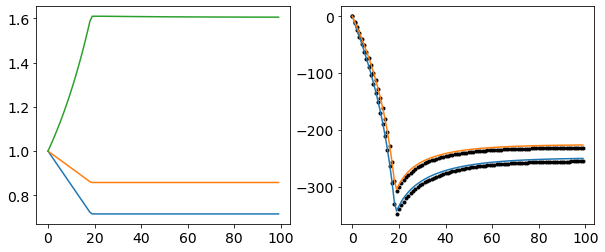

In [9]:
i=4
sigm_pr, lm1, lm2, lm3, lm1e, lm2e, lm3e = biaxial_visco(gov_params, False, time[i], lmb_x[i], lmb_y[i])
fig, ax = plt.subplots(1,2, figsize=(10,4))
ax[0].plot(time[0],lm1)
ax[0].plot(time[0],lm2)
ax[0].plot(time[0],lm3)

ax[1].plot(time[0],sgm_x[i],'k.')
ax[1].plot(time[0],sgm_y[i],'k.')
ax[1].plot(time[0],sigm_pr[:,0,0])
ax[1].plot(time[0],sigm_pr[:,1,1])

# 3. Train $\Psi_{EQ}$ and $\Psi_{NEQ}$

In [3]:
with open('saved/gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params

In [4]:
# Stuff common to both Psi_EQ and Psi_NEQ
layers = [1, 5, 5, 1]
def loss(params, lmb, sigma_gt):
    lm1 = lmb[:,0]
    lm2 = lmb[:,1]
    lm3 = lmb[:,2]
    sigma_pr = sigma_split_vmap(lm1, lm2, lm3, params)
    loss1 = np.average((sigma_pr[:,0,0]-sigma_gt[:,0,0])**2) 
    loss2 = np.average((sigma_pr[:,1,1]-sigma_gt[:,1,1])**2)
    loss3 = np.average((sigma_pr[:,2,2]-sigma_gt[:,2,2])**2)
    loss = (loss1+loss2+loss3)/3
    return  loss
    
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)

def train(loss, X, Y, opt_state, key, nIter = 10000, batch_size = 10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])         
        if it%10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss

# Generate inputs
lm = np.linspace(0.7,1.4,20)
lm1, lm2 = np.array(np.meshgrid(lm, lm))
lm1 = lm1.reshape(-1)
lm2 = lm2.reshape(-1)
lm3 = 1/(lm1*lm2)
lmb_1 = np.transpose(np.array([lm1, lm2, lm3]))
lmb_2 = np.transpose(np.array([lm1, lm2, lm3*0.95]))
lmb = np.vstack([lmb_1, lmb_2])

## 2.1 $\Psi_{EQ}$

In [5]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_eq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

# Generate outputs
sigma_gt = sigma_neoHook_vmap(lmb[:,0],lmb[:,1],lmb[:,2],gov_Psi_eq_params) #since I am using the same MM for both EQ and NEQ

# Train
opt_init, opt_update, get_params = optimizers.adam(1.e-5)
opt_state = opt_init(Psi_eq_params)
Psi_eq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 100000, batch_size = 10)
with open('saved/Psi_eq_params.npy', 'wb') as f:
    pickle.dump(Psi_eq_params, f)

it 0, train loss = 8.947643e+02
it 10000, train loss = 1.868983e+02
it 20000, train loss = 1.505081e+02
it 30000, train loss = 1.376868e+02
it 40000, train loss = 1.362692e+02
it 50000, train loss = 1.353305e+02
it 60000, train loss = 1.347625e+02
it 70000, train loss = 1.344197e+02
it 80000, train loss = 1.342208e+02
it 90000, train loss = 1.340872e+02
it 100000, train loss = 1.340030e+02


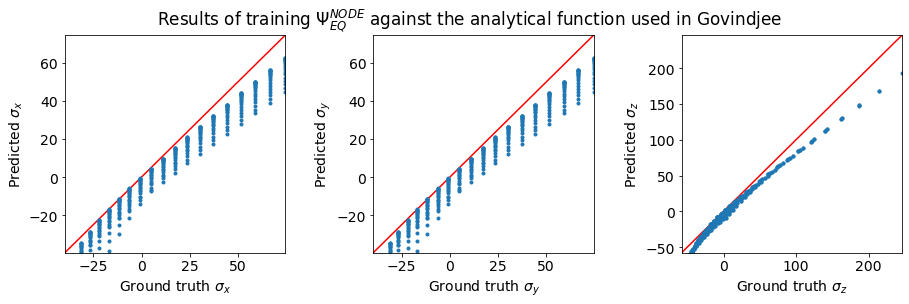

In [6]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_eq_params)
sigma_gt = sigma_neoHook_vmap(lm1, lm2, lm3, gov_Psi_eq_params) #since I am using the same MM for both EQ and NEQ
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{EQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

[Text(0.5, 0, '$\\lambda_y$'), Text(0, 0.5, '$\\lambda_z$')]

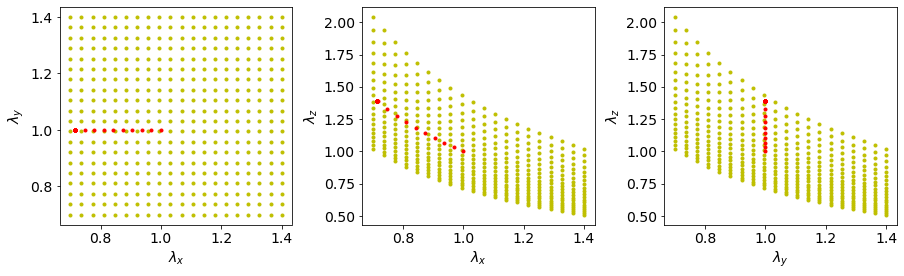

In [11]:
# fig, ax = plt.subplots(1,3,figsize=(15,4))
# fig.subplots_adjust(wspace=0.3)
# ax[0].plot(lm1,lm2, 'y.'); ax[0].plot(lm1_gov,lm2_gov,'r.')
# ax[1].plot(lm1,lm3, 'y.'); ax[1].plot(lm1_gov,lm3_gov,'r.')
# ax[2].plot(lm2,lm3, 'y.'); ax[2].plot(lm2_gov,lm3_gov,'r.')
# ax[0].set(xlabel='$\lambda_x$', ylabel='$\lambda_y$')
# ax[1].set(xlabel='$\lambda_x$', ylabel='$\lambda_z$')
# ax[2].set(xlabel='$\lambda_y$', ylabel='$\lambda_z$')

## 1.2 $\Psi_{NEQ}$

In [9]:
# Initialize parameters
I1_params = init_params_nobias(layers, key)
I2_params = init_params_nobias(layers, key)
J1_params = init_params_nobias(layers, key)
alpha = 1.0
Psi1_bias = -3.0
Psi2_bias = -3.0
NN_weights = (I1_params, I2_params, J1_params)
Psi_neq_params = (NN_weights, alpha, Psi1_bias, Psi2_bias)

# Generate outputs
sigma_gt = sigma_Ogden_vmap(lm1, lm2, lm3, gov_Psi_neq_params)

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Psi_neq_params)
Psi_neq_params, train_loss, val_loss = train(loss, lmb, sigma_gt, opt_state, key, nIter = 100000, batch_size = 10)
with open('saved/Psi_neq_params.npy', 'wb') as f:
    pickle.dump(Psi_neq_params, f)

it 0, train loss = 8.002167e+01
it 10000, train loss = 9.277240e-02
it 20000, train loss = 8.503763e-02
it 30000, train loss = 8.528869e-02
it 40000, train loss = 8.509606e-02
it 50000, train loss = 8.500368e-02
it 60000, train loss = 8.632817e-02
it 70000, train loss = 8.530033e-02
it 80000, train loss = 8.504609e-02
it 90000, train loss = 8.509133e-02
it 100000, train loss = 8.676737e-02


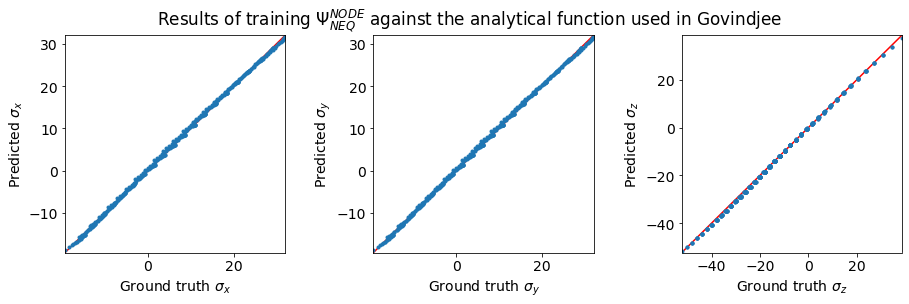

In [10]:
sigma_pr = sigma_split_vmap(lm1, lm2, lm3, Psi_neq_params)
sigma_gt = sigma_Ogden_vmap(lm1, lm2, lm3, gov_Psi_neq_params)
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_x$', '$\sigma_y$', '$\sigma_z$']
title = r"Results of training $\Psi_{NEQ}^{NODE}$ against the analytical function used in Govindjee"
plot45(gts, prs, labels, title)

# 4. Train $\Phi^{NODE}$ with $\Phi^{Govindjee}$

In [16]:
with open('saved/gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)
gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = gov_params
eta_D, eta_V = gov_Phi_params

In [17]:
# Generate training data
# Input data and normalization factors
taui = onp.mgrid[-200:200:10j, -200:200:10j, -200:200:10j]
taui = taui.reshape([3,-1]).transpose()
taui = -onp.sort(-taui)

tau1 = taui[:,0]
tau2 = taui[:,1]
tau3 = taui[:,2]
I12     = tau1**2 + tau2**2 + tau3**2 + 2*tau1*tau2 + 2*tau1*tau3 + 2*tau2*tau3
I12m3I2 = tau1**2 + tau2**2 + tau3**2 -   tau1*tau2 -   tau1*tau3 -   tau2*tau3

inp_std1 = onp.std(tau1)
inp_std2 = onp.std(tau1 + tau2)
inp_std3 = onp.std(tau1 + tau2 + tau3)
inp_std4 = onp.std(I12)
inp_std5 = onp.std(I12m3I2)
inp_stds = [inp_std1, inp_std2, inp_std3, inp_std4, inp_std5]

out_std1 = 1.0
out_std2 = 1.0
out_std3 = 1.0
out_std4 = 1/9/175000
out_std5 = 1/3/1360
out_stds = [out_std1, out_std2, out_std3, out_std4, out_std5]

# Output data
dphidtaui = onp.array(dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)).transpose()

In [18]:
# Initialize NN weights
layers = [1,2,3,1]
# NODE1_params = init_params_nobias(layers, key)
# NODE2_params = init_params_nobias(layers, key)
NODE3_params = init_params_positivebias(layers, key)
NODE4_params = init_params_positivebias(layers, key)
NODE5_params = init_params_positivebias(layers, key)
# Phi_params = [NODE1_params, NODE2_params, NODE3_params, NODE4_params, NODE5_params]
Phi_params = [NODE3_params, NODE4_params, NODE5_params]

# Train
def loss(params, taui, dphidtaui_gt):
    tau1, tau2, tau3 = taui.transpose()
    dphidtaui_pr = dPhi_vmap([tau1, tau2, tau3], params)
    loss = np.average((dphidtaui_pr[0]-dphidtaui_gt[:,0])**2)
    loss+= np.average((dphidtaui_pr[1]-dphidtaui_gt[:,1])**2)
    loss+= np.average((dphidtaui_pr[2]-dphidtaui_gt[:,2])**2)
    return loss
@partial(jit, static_argnums=(0,))
def step(loss, i, opt_state, X_batch, Y_batch):
    params = get_params(opt_state)
    g = grad(loss)(params, X_batch, Y_batch)
    return opt_update(i, g, opt_state)
def train(loss, X, Y, opt_state, key, nIter = 5000, batch_size = 100):
    global best_params
    train_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        idx_batch = random.choice(subkey, X.shape[0], shape = (batch_size,), replace = False)
        opt_state = step(loss, it, opt_state, X[idx_batch], Y[idx_batch])
        if it % 10000 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = loss(params, X, Y)
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss

opt_init, opt_update, get_params = optimizers.adam(1.e-4)
opt_state = opt_init(Phi_params)
Phi_params, train_loss = train(loss, taui, dphidtaui, opt_state, key, nIter=200000)

with open('saved/Phi_params.npy', 'wb') as f:
    pickle.dump(Phi_params, f)
with open('saved/Phi_norm_w.npy', 'wb') as f:
    pickle.dump([inp_stds, out_stds], f)

it 0, train loss = 7.562888e+00
it 10000, train loss = 6.307986e-02
it 20000, train loss = 3.141802e-03
it 30000, train loss = 5.818896e-04
it 40000, train loss = 1.659076e-04
it 50000, train loss = 5.704176e-05
it 60000, train loss = 2.243279e-05
it 70000, train loss = 9.914682e-06
it 80000, train loss = 5.008656e-06
it 90000, train loss = 2.768456e-06
it 100000, train loss = 1.692445e-06
it 110000, train loss = 1.086340e-06
it 120000, train loss = 7.468172e-07
it 130000, train loss = 5.398139e-07
it 140000, train loss = 4.128206e-07
it 150000, train loss = 3.138355e-07
it 160000, train loss = 2.556892e-07
it 170000, train loss = 2.041028e-07
it 180000, train loss = 1.731350e-07
it 190000, train loss = 1.393918e-07
it 200000, train loss = 1.195915e-07


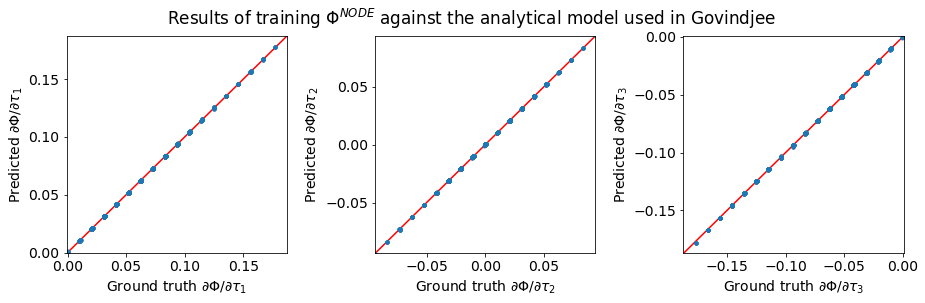

In [19]:
prs = dPhi_vmap([taui[:,0], taui[:,1], taui[:,2]], Phi_params)
gts = dPhi_gov_vmap([taui[:,0], taui[:,1], taui[:,2]], eta_D, eta_V)

labels = ['$\partial \Phi / \partial \\tau_1$', '$\partial \Phi / \partial \\tau_2$', '$\partial \Phi / \partial \\tau_3$']
title = r"Results of training $\Phi^{NODE}$ against the analytical model used in Govindjee"
plot45(gts, prs, labels, title)

# 5. Retrain the entire model with stress-stretch data

In [7]:
#Load the pre-trained parameters
with open('saved/Psi_eq_params.npy', 'rb') as f:
    Psi_eq_params = pickle.load(f)
with open('saved/Psi_neq_params.npy', 'rb') as f:
    Psi_neq_params = pickle.load(f)
with open('saved/Phi_params.npy', 'rb') as f:
    Phi_params = pickle.load(f)
with open('saved/Phi_norm_w.npy', 'rb') as f:
    [inp_stds, out_stds] = pickle.load(f)
[inp_std1, inp_std2, inp_std3, inp_std4, inp_std5] = inp_stds
[out_std1, out_std2, out_std3, out_std4, out_std5] = out_stds
params = (Psi_eq_params, Psi_neq_params, Phi_params)

with open('saved/gov_params.npy', 'rb') as f:
    gov_params = pickle.load(f)

with open('training_data/gov_data.npy','rb') as f:
    time, lmb_x, lmb_y, sgm_x, sgm_y = np.load(f)

In [13]:
def yprime_biaxial(y, t, lm1dot, lm2dot, tpeak, params, useNODE):
    lm1, lm2, lm3, lm1e, lm2e, lm3e = y

    true_fun  = lambda t: np.array([lm1dot, lm2dot])
    false_fun = lambda t: np.array([   0.0,    0.0], dtype='float64')
    lm1dot, lm2dot = cond(t<tpeak, true_fun, false_fun, t)

    if useNODE: # use NODE 
        Psi_eq_params, Psi_neq_params, Phi_params = params
        tau_A = tau_NEQ_NODE(lm1e, lm2e, lm3e, Psi_neq_params) 
        tau_A = np.array([tau_A[0,0], tau_A[1,1], tau_A[2,2]])
        dphidtaui = dPhi_NODE(tau_A, Phi_params)
    else: # use Govindjee
        gov_Psi_eq_params, gov_Psi_neq_params, gov_Phi_params = params
        eta_D, eta_V = gov_Phi_params
        tau_A = tau_Ogden(lm1e, lm2e, lm3e, gov_Psi_neq_params) 
        dphidtaui = dPhi_gov(tau_A, eta_D, eta_V)

    lm1edot = (lm1dot/lm1 - 0.5*dphidtaui[0])*lm1e
    lm2edot = (lm2dot/lm2 - 0.5*dphidtaui[1])*lm2e

    d = dsigma33([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    A = -(d[0]*lm1dot + d[1]*lm2dot + d[3]*lm1edot + d[4]*lm2edot)/d[2]
    B = -d[5]/d[2]

    Apr = A/lm3
    Bpr = B/lm3

    lm3edot = (Apr - 0.5*dphidtaui[2])/(1-Bpr*lm3e)*lm3e
    lm3dot = A + B*lm3edot
    return lm1dot, lm2dot, lm3dot, lm1edot, lm2edot, lm3edot

# @partial(jit, static_argnums=(1,))
def biaxial_visco(params, useNODE, time, lm1, lm2):
    ipeak1 = np.argmax(np.abs(np.around(lm1, 3)-1.0)) #around(lm1, 3) evenly rounds lm1 to 3 decimals
    ipeak2 = np.argmax(np.abs(np.around(lm2, 3)-1.0))
    ipeak = np.max(np.array([ipeak1,ipeak2]))
    tpeak = time[ipeak]
    lm1peak = lm1[ipeak]
    lm2peak = lm2[ipeak]

    lm1dot = (lm1peak-1.0)/tpeak
    lm2dot = (lm2peak-1.0)/tpeak
    
    # Diffrax integrator
    # yprime = lambda t, y, args: np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE))
    # term = ODETerm(yprime)
    # solver = mysolver()
    # y0 = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    # saveat = SaveAt(ts=time)
    # solution = diffeqsolve(term, solver, t0=0, t1=time[-1], dt0=0.1, y0=y0, saveat=saveat)
    # lm1, lm2, lm3, lm1e, lm2e, lm3e = solution.ys.transpose()

    # Scipy integrator
    yprime = lambda y, t: yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE)
    y0 = [1.0,1.0,1.0,1.0,1.0,1.0]
    lm1, lm2, lm3, lm1e, lm2e, lm3e = odeint(yprime, y0, time).transpose()

    # Manual forward Euler
    # n = 999
    # dt = time[-1]/n
    # time = np.linspace(0, time[-1], n)
    # y = np.array([1.0,1.0,1.0,1.0,1.0,1.0])
    # y_hist = [y]
    # for i in range(n):
    #     t = time[i]
    #     dy = np.array(yprime_biaxial(y,t,lm1dot,lm2dot,tpeak,params,useNODE))
    #     y_new = y + dy*dt
    #     y_hist.append(y_new)
    #     y = y_new
    #     pass
    # lm1, lm2, lm3, lm1e, lm2e, lm3e = np.array(y_hist).transpose()
    

    sig = getsigma([lm1,lm2,lm3,lm1e,lm2e,lm3e], params, useNODE)
    return sig, lm1, lm2, lm3, lm1e, lm2e, lm3e

In [ ]:
i=0
t = time[0]
sig_NN, lm1_NN, lm2_NN, lm3_NN, lm1e_NN, lm2e_NN, lm3e_NN  = biaxial_visco(params,     True,  t, lmb_x[i],lmb_y[i])
sig_gov,lm1_gov,lm2_gov,lm3_gov,lm1e_gov,lm2e_gov,lm3e_gov = biaxial_visco(gov_params, False, t, lmb_x[i],lmb_y[i])

t = np.linspace(0, t[-1], sig_NN.shape[0])

fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(t,lm1_gov, 'k.')
ax[0].plot(t,lm2_gov, 'b.')
ax[0].plot(t,lm3_gov, 'g.')
ax[0].plot(t,lm1_NN, 'k-')
ax[0].plot(t,lm2_NN, 'b-')
ax[0].plot(t,lm3_NN, 'g-')

ax[1].plot(t,sig_gov[:,0,0],'k.')
ax[1].plot(t,sig_gov[:,1,1],'b.')
ax[1].plot(t,sig_gov[:,2,2],'g.')
ax[1].plot(t,sig_NN[:,0,0],'k-')
ax[1].plot(t,sig_NN[:,1,1],'b-')
ax[1].plot(t,sig_NN[:,2,2],'g-')

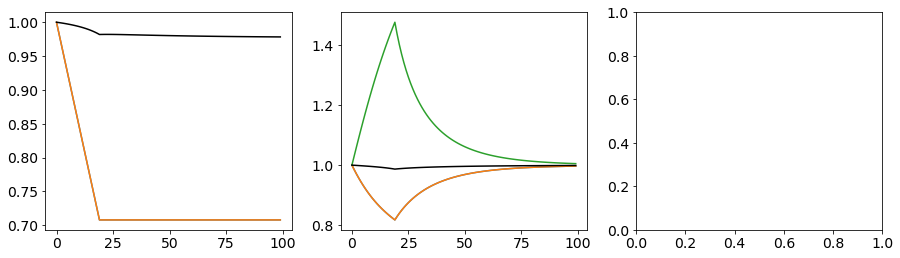

In [25]:
fig, ax = plt.subplots(1,3,figsize=(15,4))
ax[0].plot(lm1_NN)
ax[0].plot(lm2_NN)

ax[0].plot(lm1_NN*lm2_NN*lm3_NN, 'k')

ax[1].plot(lm1e_NN)
ax[1].plot(lm2e_NN)
ax[1].plot(lm3e_NN)
ax[1].plot(lm1e_NN*lm2e_NN*lm3e_NN, 'k')

In [26]:
from NODE_fns import sigma_split_vmap

In [27]:
sigma_pr = sigma_split_vmap(lm1_gov, lm2_gov, lm3_gov, Psi_eq_params)
sigma_gt = sigma_Ogden_vmap(lm1_gov, lm2_gov, lm3_gov, gov_Psi_eq_params)

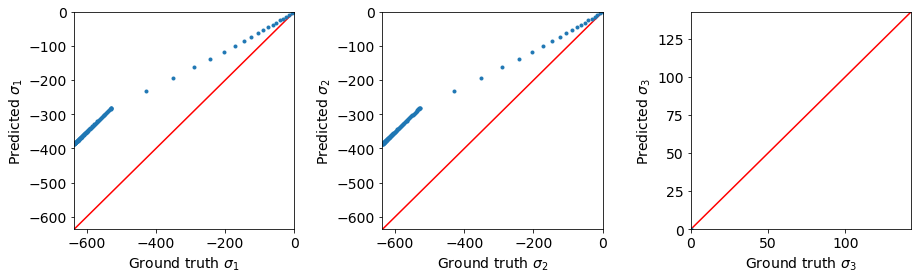

In [28]:
gts = [sigma_gt[:,0,0], sigma_gt[:,1,1], sigma_gt[:,2,2]]
prs = [sigma_pr[:,0,0], sigma_pr[:,1,1], sigma_pr[:,2,2]]
labels = ['$\sigma_1$', '$\sigma_2$', '$\sigma_3$']
title = ''
plot45(gts, prs, labels, title)

In [ ]:
def loss(params, useNODE, time, lm1, sigma1):
    sigma_pr,_,_,_,_,_,_ = triaxial_visco(params, useNODE, time, lm1)
    loss = np.sqrt((sigma_pr[:,0,0]-sigma1[:])**2)
    return loss/lm1.shape[0]
loss_vmap = vmap(loss, in_axes=(None, None, 0, 0, 0), out_axes=0)
batch_loss = lambda params, useNODE, time, lm1, sigma1: np.mean(loss_vmap(params, useNODE, time, lm1, sigma1))

@partial(jit, static_argnums=(0,1,))
def step(loss_fn, useNODE, i, opt_state, X1_batch, X2_batch, Y1_batch):
    params = get_params(opt_state)
    g = grad(loss_fn, argnums=0)(params, useNODE, X1_batch, X2_batch, Y1_batch)
    return opt_update(i, g, opt_state)

def train(X1, X2, Y1, opt_state, key, nIter = 1000, batch_size=10):
    train_loss = []
    val_loss = []
    for it in range(nIter+1):
        key, subkey = random.split(key)
        i = random.choice(subkey, X1.shape[0], shape=(batch_size,), replace = False)
        i = tuple([i])
        opt_state = step(batch_loss, True, it, opt_state, X1[i], X2[i], Y1[i])
        if it % 100 == 0 or it == nIter:
            params = get_params(opt_state)
            train_loss_value = batch_loss(params, True, X1[i], X2[i], Y1[i])
            train_loss.append(train_loss_value)
            to_print = "it %i, train loss = %e" % (it, train_loss_value)
            print(to_print)
    return get_params(opt_state), train_loss, val_loss 

opt_init, opt_update, get_params = optimizers.adam(5.e-5)
opt_state = opt_init(params)

params, train_loss, val_loss = train(time, lamb, sigm, opt_state, key, nIter = 3000, batch_size=2)
with open('saved/params_retrained.npy', 'wb') as f:
    pickle.dump(params, f)

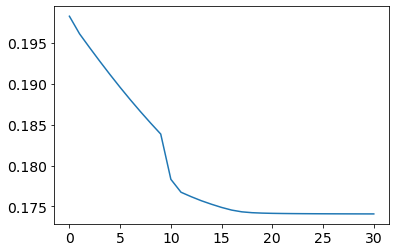

In [42]:
plt.plot(train_loss)

# 5. Testing

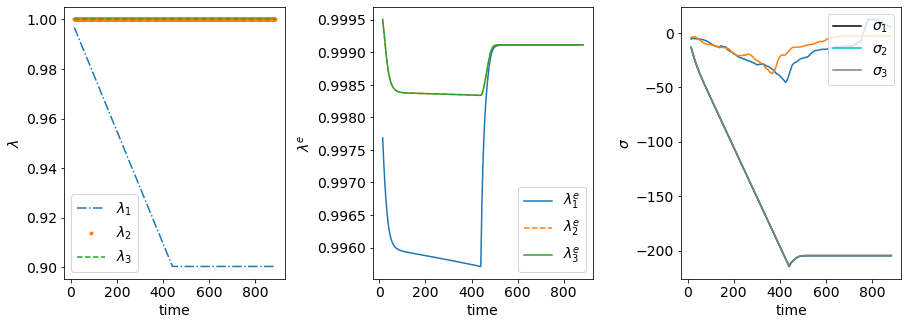

In [43]:
with open('saved/P01_params_retrained.npy', 'rb') as f:
    params = pickle.load(f)
t = time[0]
sig,lm1,lm2,lm3,lm1e,lm2e,lm3e = triaxial_visco(params, True, t, lamb[0])

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.subplots_adjust(wspace=0.4)

ax[0].plot(t, lm1, '-.',label='$\lambda_1$')
ax[0].plot(t, lm2, '.',label='$\lambda_2$')
ax[0].plot(t, lm3, '--',label='$\lambda_3$')
ax[0].set(xlabel='time', ylabel='$\lambda$')
ax[0].legend() 

ax[1].plot(t, lm1e, label='$\lambda_1^e$')
ax[1].plot(t, lm2e, '--', label='$\lambda_2^e$')
ax[1].plot(t, lm3e, label='$\lambda_3^e$')
ax[1].set(xlabel='time', ylabel='$\lambda^e$')
ax[1].legend()

ax[2].plot(t, sigm[0])
ax[2].plot(t, sigm[1])
ax[2].plot(t, sig[:,0,0], 'k-',label='$\sigma_1$')
ax[2].plot(t, sig[:,1,1], 'c-',label='$\sigma_2$')
ax[2].plot(t, sig[:,2,2], 'gray',label='$\sigma_3$')
ax[2].set(xlabel='time', ylabel='$\sigma$')
ax[2].legend(loc='upper right') 
pass